# Explore Simple Cuts

In [1]:
from tomo_challenge import load_data, load_redshift
from tomo_challenge.jax_metrics import ell_binning

Found classifier Random
Found classifier RandomForest
Found classifier IBandOnly


In [2]:
from zotbin.binned import *

In [3]:
init_data = load_binned('binned_28.npz')

Specify the challenge data to use:

In [4]:
bands='griz'
include_colors=False
include_errors=False

In [5]:
train_file='/media/data2/tomo_challenge_data/ugrizy/training.hdf5'
train_data = load_data(train_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
train_z = load_redshift(train_file)
print(f'Loaded {len(train_data)} training rows.')

/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


Loaded 8615613 training rows.


In [6]:
def scan(feature, z, pct):
    ncut = len(pct)
    cuts = np.percentile(feature, pct)
    ibin = np.digitize(feature, cuts)
    score_data = None
    for i in range(ncut):
        idx = 1 * (ibin <= i)
        scores = get_binned_scores(idx, z, *init_data)
        if score_data is None:
            score_data = {t: np.empty(ncut) for t in scores}
        for t in scores:
            score_data[t][i] = scores[t]
    return score_data, cuts

In [7]:
def study_cuts(data, z, ncut=50):
    nband = data.shape[1]
    assert nband == len(bands)
    pct = np.linspace(0, 100, ncut + 2)[1:-1]
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    # Apply cuts in each band.
    for iband in range(nband):
        scores, cuts = scan(data[:, iband], z, pct)
        for i, t in enumerate(scores):
            axes[i].plot(pct, scores[t], '-', label=f'{bands[iband]}')
    # Apply cuts in each color.
    for iband in range(1, nband):
        scores, cuts = scan(data[:, iband] - data[:, iband - 1], z, pct)
        for i, t in enumerate(scores):
            axes[i].plot(pct, scores[t], '-', label=f'{bands[iband]}-{bands[iband - 1]}')        
    for ax, t in zip(axes, scores.keys()):
        ax.set_ylim(0, None)
        ax.set_ylabel(t)
        ax.set_xlabel('Percentile Cut')
        ax.legend(ncol=2)        
    plt.tight_layout()

CPU times: user 40.6 s, sys: 2.59 s, total: 43.2 s
Wall time: 39.7 s


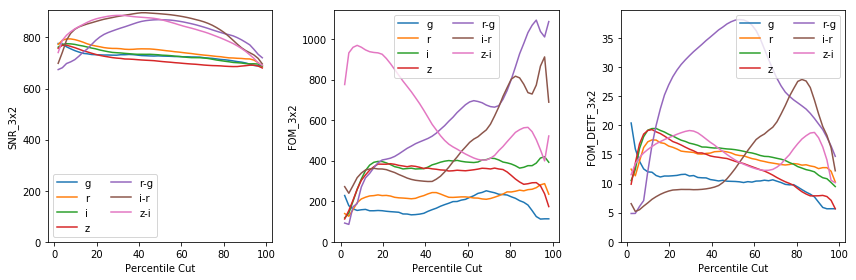

In [8]:
%time study_cuts(train_data[:100000], train_z[:100000])